In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["JAX_PLATFORMS"] = "cpu"

In [3]:
from bpd.sample import sample_galaxy_params_simple, sample_ellip_prior
from functools import partial 

import jax 
from jax import vmap

import jax.numpy as jnp

import matplotlib.pyplot as plt 
import numpy as np

In [6]:
np.arange(10, 81, 10)

array([10, 20, 30, 40, 50, 60, 70, 80])

## Ellipticity

In [101]:
key =jax.random.key(42)

k1, k2 = jax.random.split(key, 2)

In [102]:
es =sample_ellip_prior(k1, sigma=0.2, n=100000)

In [103]:
es.shape

(100000, 2)

In [104]:
mag = jnp.sqrt(es[:, 0]**2 + es[:, 1]**2)
idx = jnp.argmax(mag)
es[idx], mag[idx]

(Array([-0.84875464, -0.24917875], dtype=float64),
 Array(0.88457588, dtype=float64))

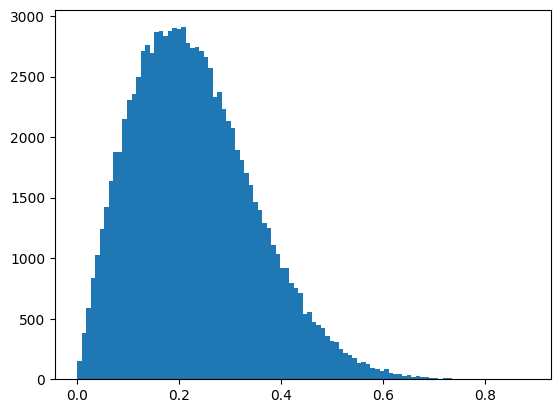

In [105]:
plt.hist(mag, bins=100);

In [106]:
k2s = jax.random.split(k2, 100000)
hlr = 10 ** ( vmap(jax.random.normal)(k2s) * 0.05 + -0.4)
hlr.shape

(100000,)

In [107]:
import galsim
gal = galsim.Exponential(half_light_radius=2.0,flux=10000.0)
gal.calculateFWHM(), gal.half_light_radius

(np.float64(1.6521496619118223), 2.0)

## Image size

In [108]:
# image size
import galsim 
def get_exponential_size(f, hlr, e1, e2, psf_fwhm):

    gal = galsim.Exponential(flux=f, half_light_radius=hlr)
    gal = gal.shear(g1=e1, g2=e2)  # intrinsic ellipticity

    psf = galsim.Gaussian(flux=1.0, fwhm=psf_fwhm)
    gal_conv = galsim.Convolve([gal, psf])
    return gal_conv.getGoodImageSize(0.2)


In [88]:
from tqdm import tqdm

ss = [] 
for ii in tqdm(range(100000)):
    ss.append(get_exponential_size(1e5, hlr[ii], es[ii, 0], es[ii, 1], psf_fwhm=0.8))

ss = jnp.array(ss)

100%|██████████| 100000/100000 [00:58<00:00, 1704.31it/s]


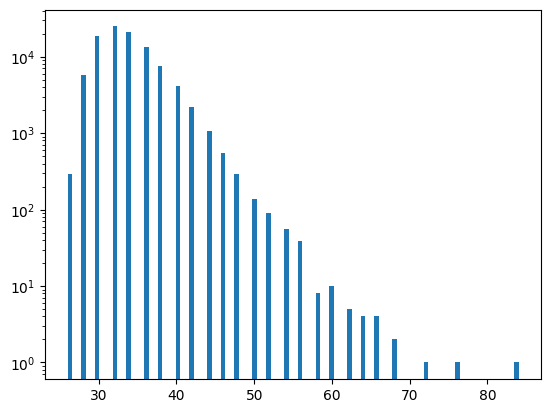

In [89]:
plt.hist(ss, bins=100);
plt.yscale('log')

In [90]:
jnp.quantile(ss, 0.999)

Array(54., dtype=float64)

In [91]:
10**-0.4

0.3981071705534972

## SNR

In [109]:
seed = 42 
k = jax.random.key(42)
keys = jax.random.split(k, 10000)

In [110]:
_sample_fnc = partial(sample_galaxy_params_simple, 
                      shape_noise=0.1, mean_logflux=2.5, sigma_logflux=0.4, mean_loghlr=-0.4, sigma_loghlr=0.05)
galaxy_params = vmap(_sample_fnc)(keys)

In [111]:
draw_params = {**galaxy_params}
draw_params['f'] = 10**draw_params.pop("lf")
    draw_params['hlr'] = 10**draw_params.pop("lhlr")
draw_params['x'] = jnp.zeros_like(draw_params['x'])
draw_params['y'] = jnp.zeros_like(draw_params['y'])

draw_params.keys()

dict_keys(['e1', 'e2', 'g1', 'g2', 'x', 'y', 'f', 'hlr'])

In [112]:
from bpd.draw import draw_exponential_galsim
from tqdm import tqdm


_draw_galsim = partial(draw_exponential_galsim, slen=63)
noiseless = [] 



for ii in tqdm(range(10000)):
    _params = {k:v[ii] for k,v in draw_params.items()}
    noiseless.append(_draw_galsim(**_params))


noiseless = jnp.stack(noiseless, axis=0)

100%|██████████| 10000/10000 [00:16<00:00, 613.95it/s]


In [113]:
noiseless.shape

(10000, 63, 63)

In [114]:
from bpd.utils import get_snr

snrs = [] 
for ii in tqdm(range(10000)):
    snrs.append(get_snr(noiseless[ii], 1.0))

snrs = jnp.stack(snrs, axis=0)

100%|██████████| 10000/10000 [00:01<00:00, 5424.62it/s]


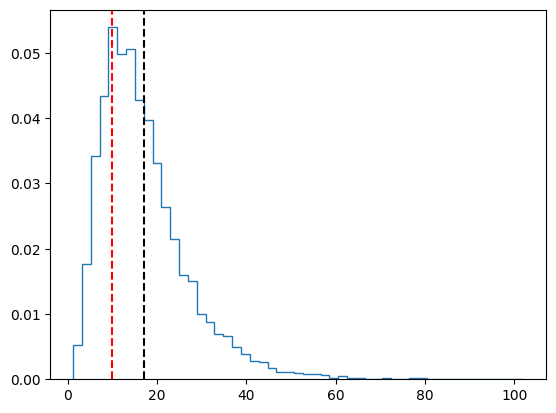

In [115]:
plt.hist(snrs, bins=51, histtype='step', density=True)
plt.axvline(snrs.mean(), linestyle='--', color='k')
plt.axvline(10.0, linestyle='--', color='r')

In [116]:
jnp.median(snrs), snrs.mean()

(Array(14.965368, dtype=float32), Array(17.077452, dtype=float32))

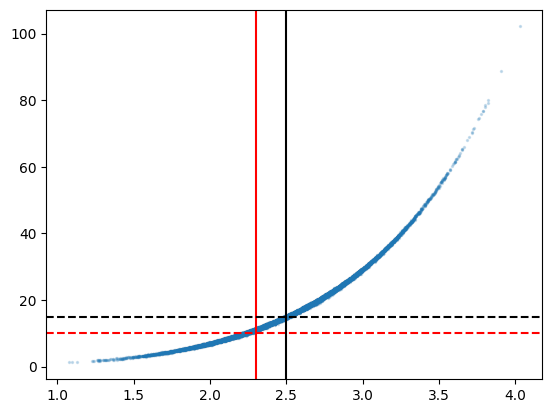

In [117]:
plt.scatter(galaxy_params['lf'],  snrs, marker='o', s=2., alpha=0.2)
plt.axhline(10., color='r', linestyle='--')
plt.axvline(2.3, color='r')

plt.axhline(15., color='k', linestyle='--')
plt.axvline(2.5, color='k', linestyle='-')

In [123]:
# get interpolation
x = np.linspace(1.0, 4.0, 10000)

mask = np.argsort(galaxy_params['lf'])
lf_sorted = galaxy_params['lf'][mask]
f_new = np.interp(x, lf_sorted, snrs[mask])

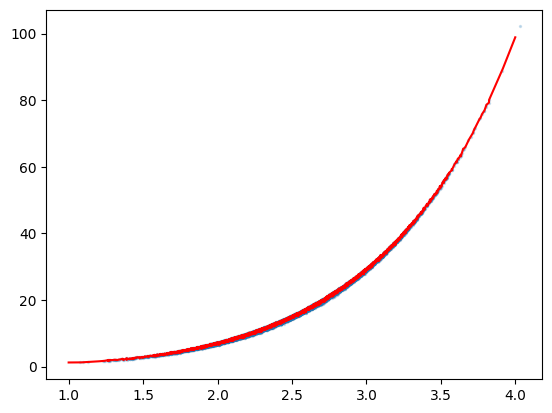

In [124]:
plt.scatter(galaxy_params['lf'],  snrs, marker='o', s=2., alpha=0.2)
plt.plot(x, f_new, '-r')

# No truncation, very steep

In [145]:
from scipy.stats import lognorm, skewnorm, norm
import numpy as np 

In [151]:
# samples of new flux from skewnorm
rng = np.random.RandomState(42)
lfs = skewnorm.rvs(a=14, loc=2.45, scale=0.4, random_state=rng, size=(10000,))
lfs.shape

(10000,)

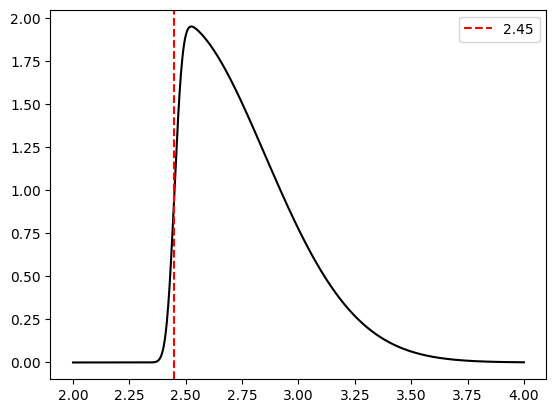

In [154]:
x = np.linspace(2.0, 4.0, 1000)
y = skewnorm.pdf(x, a=14, loc=2.45, scale=0.4)

x2 = (x - 2.45) / 0.4
y2 = 2 * norm.pdf(x2) * norm.cdf(14 * x2) / 0.4

plt.plot(x, y, 'k-')
# plt.plot(x, y2, 'c-.')
# plt.hist(lfs, density=True, bins=31, histtype='step')
# plt.yscale('log')
plt.axvline(2.45, c='r', ls='--', label='2.45')
# plt.axvline(2.5, c='r', ls='--')
plt.legend()

In [135]:
snrs_new = np.interp(lfs, galaxy_params['lf'][mask], snrs[mask])

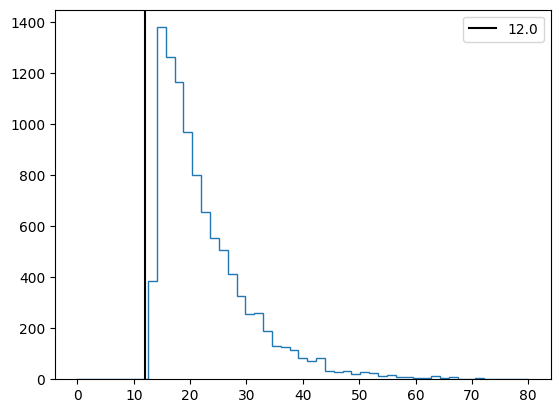

In [156]:
plt.hist(snrs_new, bins=51, histtype='step', range=(0, 80), )
plt.axvline(12.0, c='k', label='12.0')
plt.legend()
# plt.axvline(15.0, c='k')

In [142]:
snrs_new.min()

np.float64(12.250057405569194)